In [3]:
from typing import List, Dict
import torch

import sys 
sys.path.append("Attend-and-Excite")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore
from utils import ptp_utils
from diffusers import AutoencoderKL

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model Weights (may take a few minutes)

In [4]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base",safety_checker=None).to(device)
tokenizer = stable.tokenizer

vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="vae").to("cpu")
vae.eval()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

# Pipeline Wrapper

In [14]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite

def run_on_prompt(prompt: List[str],
                  model: AttendAndExcitePipeline,
                  controller: AttentionStore,
                  token_indices: List[int],
                  seed: torch.Generator,
                  config: RunConfig,
                  latent):
    if controller is not None:
        ptp_utils.register_attention_control(model, controller)
    outputs = model(prompt=prompt,
                    attention_store=controller,
                    indices_to_alter=token_indices,
                    attention_res=config.attention_res,
                    guidance_scale=config.guidance_scale,
                    generator=seed,
                    num_inference_steps=config.n_inference_steps,
                    max_iter_to_alter=config.max_iter_to_alter,
                    run_standard_sd=config.run_standard_sd,
                    thresholds=config.thresholds,
                    scale_factor=config.scale_factor,
                    scale_range=config.scale_range,
                    smooth_attentions=config.smooth_attentions,
                    sigma=config.sigma,
                    kernel_size=config.kernel_size, 
                    latents=latent)
    image = outputs.images[0]
    return image


def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    latent = None,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config,
                         latent=latent)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [15]:
cls = 'dog'
seed = 21
do_ddim_inversion = True
instance = 1000
token_indices = [1]

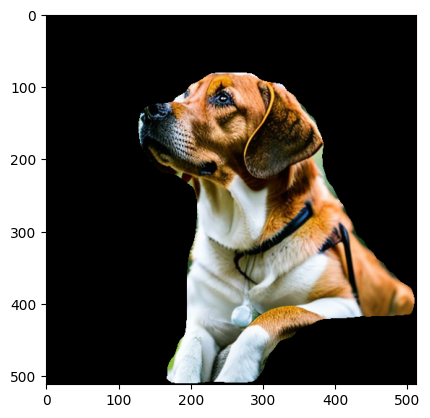

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


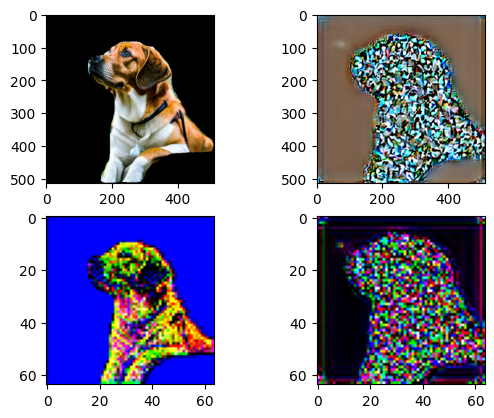

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, AutoencoderKL

def decode_latents(vae, latent):
    latent = 1 / 0.18215 * latent
    image = vae.decode(latent).sample                                            
    image = (image / 2 + 0.5).clamp(0, 1)                                              
    image = image.cpu().permute(0, 2, 3, 1).float().detach().numpy() # for some reason crashes if using stable diffusion
    return image

x_inv = torch.load(f'/grogu/user/akirchme/art3d_sd_webui/inversion/{cls}/{instance}.pt')
img_orig = Image.open(f'/grogu/user/akirchme/art3d_sd_webui/fg/{cls}/{instance}.png')
latent = x_inv[-1,:,:,:].unsqueeze(0)


plt.imshow(img_orig)
plt.show()

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(decode_latents(vae, x_inv[0:1]).squeeze())
axs[0,1].imshow(decode_latents(vae, x_inv[-1:]).squeeze())
axs[1,0].imshow(x_inv[0,:3,:,:].permute(1,2,0))
axs[1,1].imshow(x_inv[-1,:3,:,:].permute(1,2,0))
plt.show()

## Stable Diffusion

In [ ]:
g = torch.Generator('cuda').manual_seed(seed)
prompts = [cls]
controller = AttentionStore()
image = run_and_display(prompts=prompts,
                        controller=controller,
                        indices_to_alter=token_indices,
                        generator=g,
                        run_standard_sd=True,
                        display_output=True,
                        latent=latent)

res=1 where=down
res=1 where=mid
res=1 where=up
res=2 where=down
res=2 where=mid
res=2 where=up
res=4 where=down
res=4 where=mid
res=4 where=up
res=8 where=down
res=8 where=mid


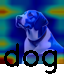

res=8 where=up
res=16 where=down


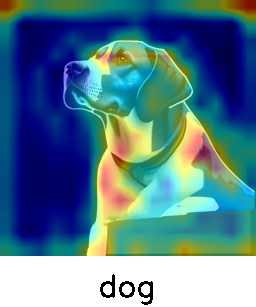

res=16 where=mid
res=16 where=up


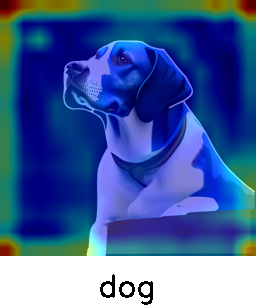

res=32 where=down


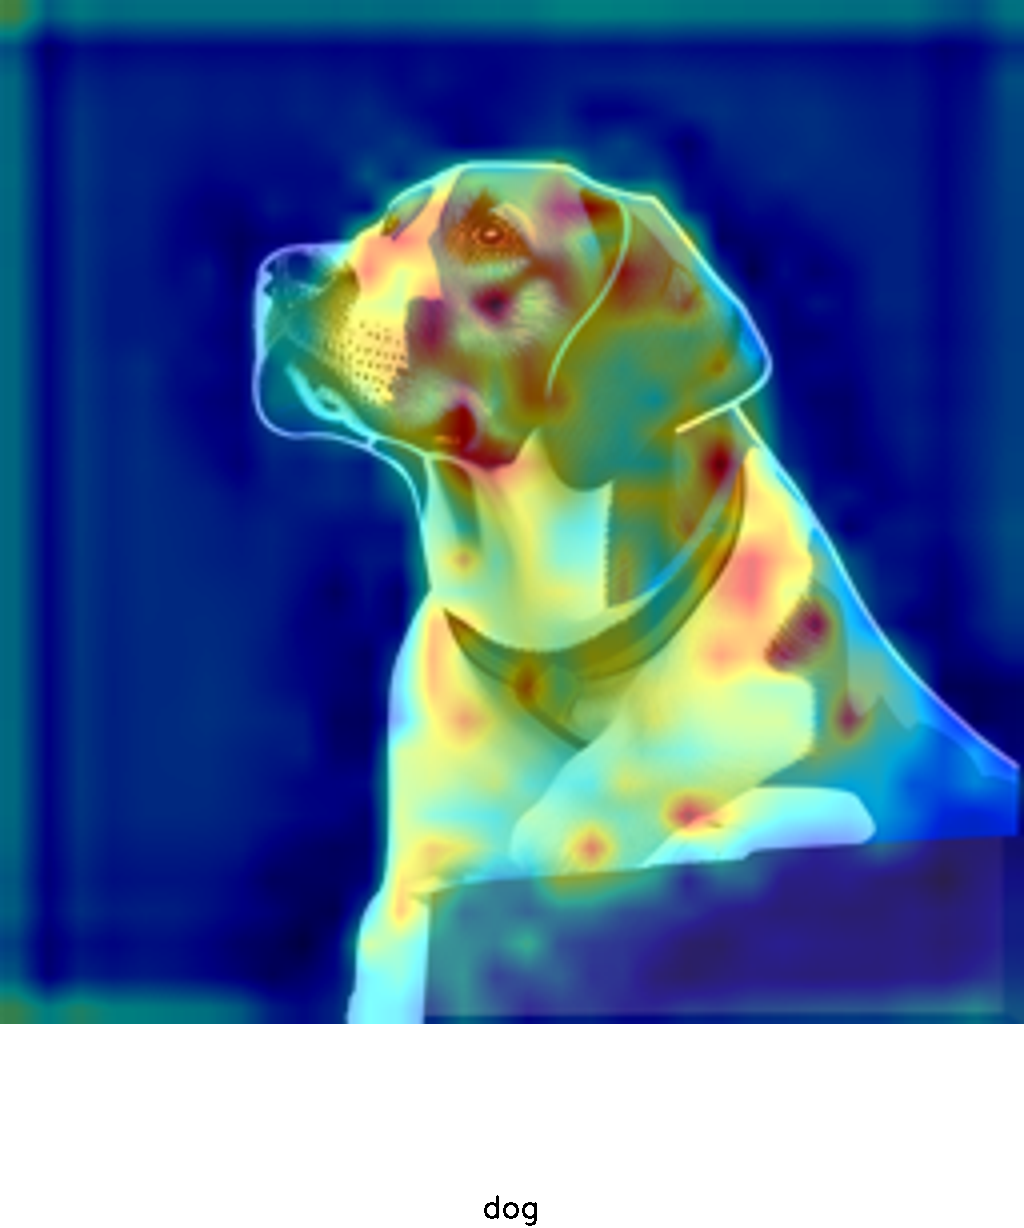

res=32 where=mid
res=32 where=up


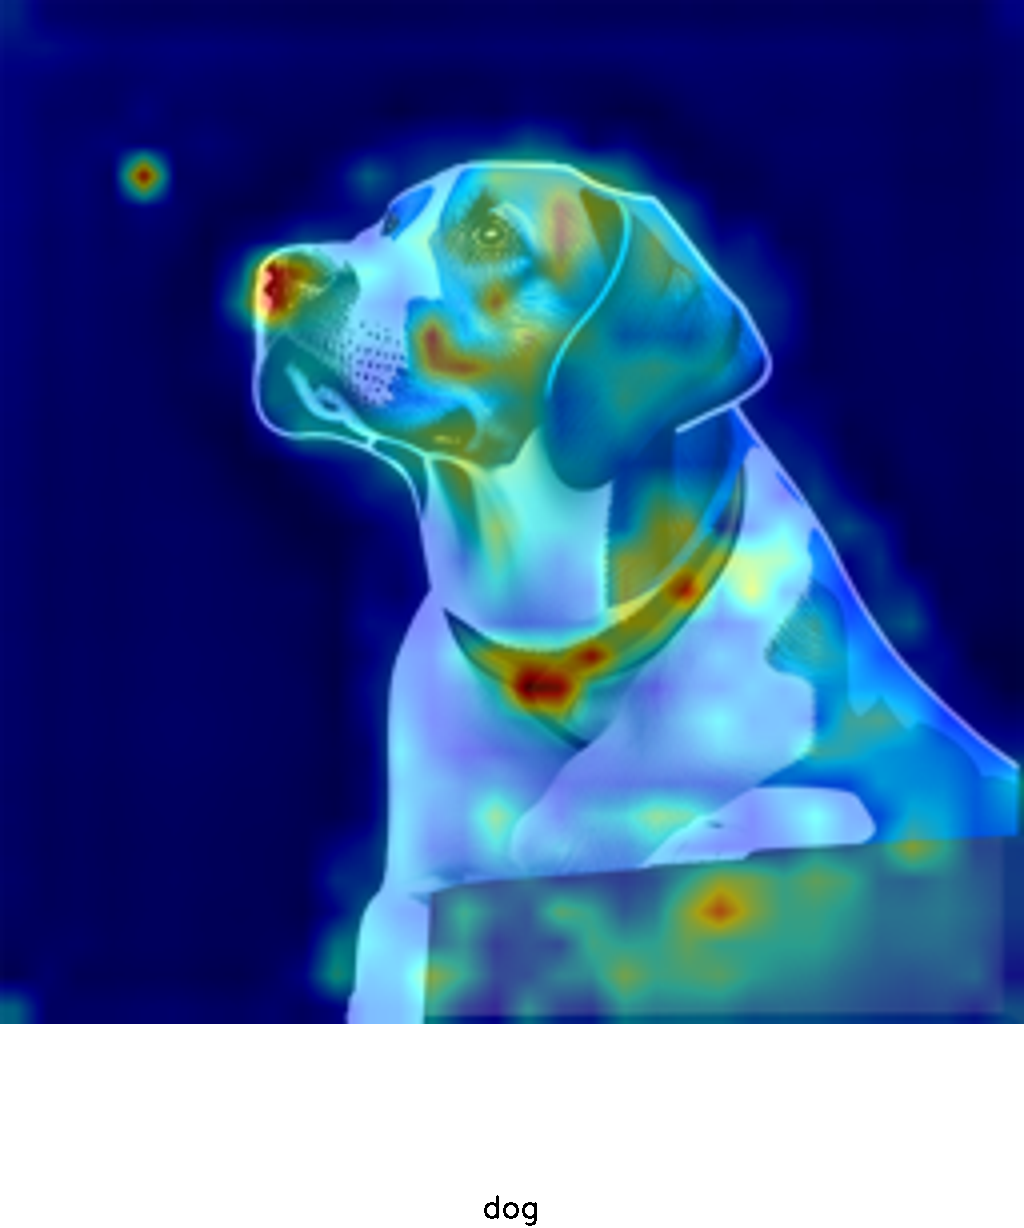

res=64 where=down
res=64 where=mid
res=64 where=up


In [28]:

for res in [1, 2, 4, 8, 16, 32, 64]:
    for where in ['down', 'mid', 'up']:
        try:
            print(f'res={res} where={where}')
            vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=cls,
                                   tokenizer=tokenizer,
                                   res=res,
                                   from_where=(where,),
                                   indices_to_alter=token_indices,
                                   orig_image=image)
        except:
            pass